In [56]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation as mad
from scipy.stats import spearmanr, pearsonr
import numpy as np
import gseapy as gp
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm


In [57]:
tang_adata = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/tang_adata_qc_filtered.h5ad")


In [58]:
lung_cells = pd.read_csv("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/lung_cells_gene_expr.csv")

/tmp/ipykernel_822981/2633038527.py:1: DtypeWarning: Columns (22,23,24,27,34,36,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  lung_cells = pd.read_csv("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/lung_cells_gene_expr.csv")


In [59]:
tumor_adata = tang_adata[tang_adata.obs['tissue_type'] == 'PT', :]
tumor_adata = tumor_adata[tumor_adata.obs['cell_type'] == 'tumor', :]
tumor_adata_filtered = tumor_adata[~tumor_adata.obs['patient'].isin(['P1', 'P14']), :]

In [60]:
tumor_adata_filtered

View of AnnData object with n_obs × n_vars = 1757 × 21395
    obs: 'patient', 'NT', 'tissue', 'cell_type', 'tissue_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet_score', 'predicted_doublet'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cells_removed', 'scrublet'

<Axes: xlabel='total_counts', ylabel='Count'>

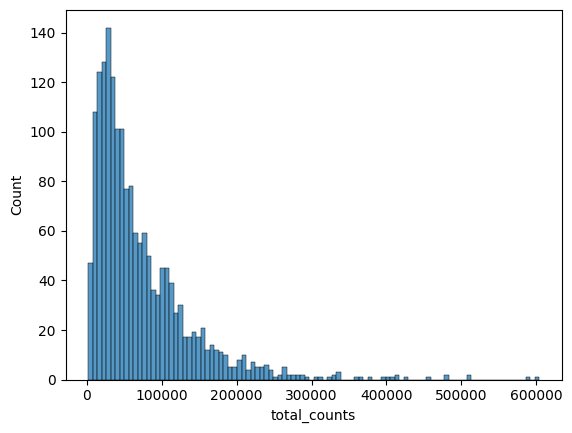

In [61]:
p1 = sns.histplot(tumor_adata_filtered.obs["total_counts"], bins=100, kde=False)
p1

In [62]:
scales_counts = sc.pp.normalize_total(tumor_adata_filtered, target_sum=1e6, inplace=False, exclude_highly_expressed=True)
# log1p transform
tumor_adata_filtered.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

/hpc/packages/minerva-rocky9/py_packages/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


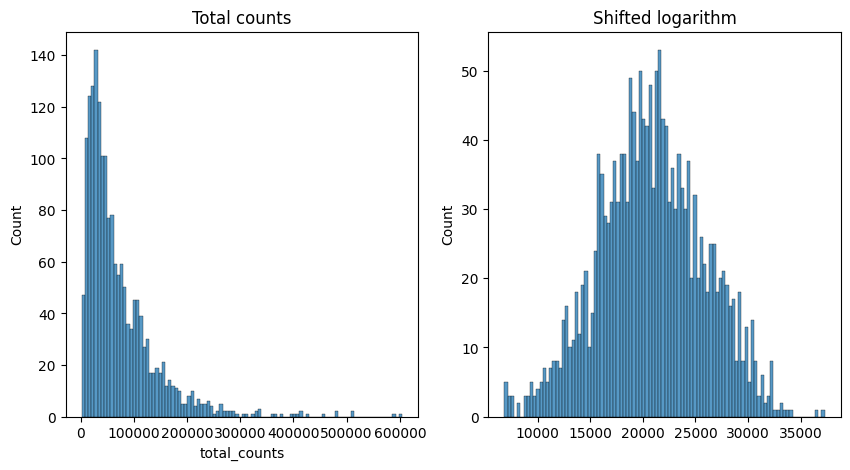

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(tumor_adata_filtered.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(tumor_adata_filtered.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [64]:
tumor_adata_normalized = sc.AnnData(
    X = tumor_adata_filtered.layers["log1p_norm"],
    obs = tumor_adata_filtered.obs.copy(),
    var = tumor_adata_filtered.var.copy(),
    uns = tumor_adata_filtered.uns.copy(),
    layers = tumor_adata_filtered.layers.copy()
)


In [65]:
sc.pp.highly_variable_genes(tumor_adata_normalized, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(tumor_adata_normalized.var.highly_variable))

Highly variable genes: 3425


In [69]:
sc.pp.pca(tumor_adata_normalized, svd_solver="arpack")


In [70]:
sc.tl.tsne(tumor_adata_normalized, use_rep="X_pca")


In [71]:
sc.pp.neighbors(tumor_adata_normalized)
sc.tl.umap(tumor_adata_normalized)

<Axes: title={'center': 'Tian et al. (n=1757)'}, xlabel='UMAP1', ylabel='UMAP2'>

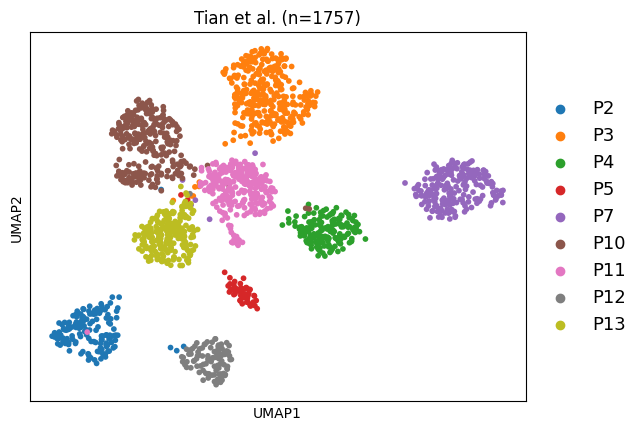

In [73]:
# UMAP did not segregate according to any QC metric
sc.pl.umap(tumor_adata_normalized, color="patient",title="Tian et al. (n=1757)", add_outline=False,show=False,legend_fontsize=13)
#plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/plots/tian_umap_patients.png", dpi=600,bbox_inches='tight')

In [74]:
NE_genes = ['KIF1A', 'GNAO1','DPYSL5','SYP','CHGA','KIF5C','SCAMP5','TUBB2B','SCG3','GNG4','CRMP1','RUNDC3A','CHRNB2','BEX1','PGBD5','CHGB','RAB39A', 'NCAM1','TMEM198','AP3B2','UNC13A','MAPK8IP1','SNAP25','SOGA3','INSM1']
non_NE_genes = ['HFE','ITGB4','IL18','ANXA3','CAV2','GPRC5A','AHNAK','ADGRG6','IFITM3','CAV1','EPHA2','GPX8','LGALS3','CYR61','RHBDF1','NT5E','WWTR1','NABP1','OSMR','YAP1','TGFBR2','ANXA1','S100A16','MYOF','EMP1']

In [75]:
combined_avg_expression = pd.read_csv("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/ne_non_ne_gene_expr.csv", index_col=0)
combined_avg_expression = combined_avg_expression.rename(index={'CCN1': 'CYR61'})
lung_cells.rename(columns={"CCN1": "CYR61"}, inplace=True)
lung_cells.set_index("StrippedCellLineName", inplace=True)

In [76]:
lung_cells_subset = lung_cells[NE_genes+non_NE_genes]

In [77]:
adata_ne_score_genes = tumor_adata_normalized.layers['log1p_norm'][:, [tumor_adata_normalized.var_names.get_loc(gene) for gene in NE_genes+non_NE_genes]]

In [78]:
pearson_correlation_to_ne = []
pearson_correlation_to_nonne = []

for cell_idx in range(adata_ne_score_genes.shape[0]):
    cell_expression = adata_ne_score_genes[cell_idx, :].flatten()
    nonzero_mask = cell_expression != 0
    
    avg_ne_expression = combined_avg_expression.loc[NE_genes+non_NE_genes, 'NE_cells'].values
    avg_nonne_expression = combined_avg_expression.loc[NE_genes+non_NE_genes, 'non_NE_cells'].values
    
    filtered_cell_expr = cell_expression[nonzero_mask]
    filtered_avg_ne_expr = avg_ne_expression[nonzero_mask]
    filtered_avg_nonne_expr = avg_nonne_expression[nonzero_mask]
    
    if len(filtered_cell_expr) < 5:
        pearson_correlation_to_ne.append(np.nan)
        pearson_correlation_to_nonne.append(np.nan)
    else:
        # Check if filtered reference vector is still constant
        if np.std(filtered_cell_expr) == 0 or np.std(filtered_avg_ne_expr) == 0 or np.std(filtered_avg_nonne_expr) == 0:
            pearson_correlation_to_ne.append(np.nan)
            pearson_correlation_to_nonne.append(np.nan)
        else:
            ne_correlation, _ = pearsonr(filtered_cell_expr, filtered_avg_ne_expr)
            nonne_correlation, _ = pearsonr(filtered_cell_expr, filtered_avg_nonne_expr)
            pearson_correlation_to_ne.append(ne_correlation)
            pearson_correlation_to_nonne.append(nonne_correlation)


In [79]:
ref_pearson_correlation_to_ne = []
ref_pearson_correlation_to_nonne = []

for cell_idx in lung_cells_subset.index:
    # Get the expression values for the current cell (row)
    lung_cells_subset_expr = lung_cells_subset.loc[cell_idx, :].values  # Get expression values as a numpy array
    
    # Get the average expression for NE and non-NE cells
    avg_ne_expression = combined_avg_expression.loc[NE_genes + non_NE_genes, 'NE_cells'].values
    avg_nonne_expression = combined_avg_expression.loc[NE_genes + non_NE_genes, 'non_NE_cells'].values

    # Calculate Pearson correlation for NE cells
    ne_correlation, _ = pearsonr(lung_cells_subset_expr, avg_ne_expression)

    # Calculate Pearson correlation for non-NE cells
    nonne_correlation, _ = pearsonr(lung_cells_subset_expr, avg_nonne_expression)

    # Append the results to the respective lists
    ref_pearson_correlation_to_ne.append(ne_correlation)
    ref_pearson_correlation_to_nonne.append(nonne_correlation)

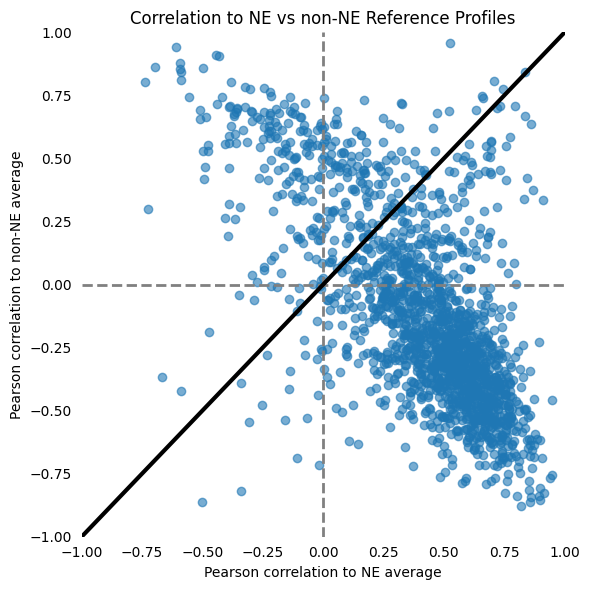

In [80]:
x=pearson_correlation_to_ne
y=pearson_correlation_to_nonne

plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.6)

# Set axis limits
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Axis labels and title
plt.xlabel('Pearson correlation to NE average')
plt.ylabel('Pearson correlation to non-NE average')
plt.title('Correlation to NE vs non-NE Reference Profiles')

# Add x=0 and y=0 lines
plt.axhline(0, color='gray', linestyle='--', linewidth=2)
plt.axvline(0, color='gray', linestyle='--', linewidth=2)

# Add diagonal line
plt.plot([-1, 1], [-1, 1], linewidth=3, color='Black')

# Remove outer spines
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)

# Optional: remove ticks
plt.tick_params(left=False, bottom=False)

plt.grid(False)
plt.tight_layout()
plt.show()

In [81]:
lung_cells_subset["NE_score"] = (np.array(ref_pearson_correlation_to_ne) - np.array(ref_pearson_correlation_to_nonne))/2

/tmp/ipykernel_822981/2485471969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lung_cells_subset["NE_score"] = (np.array(ref_pearson_correlation_to_ne) - np.array(ref_pearson_correlation_to_nonne))/2


In [82]:
tumor_adata_normalized.obs['pearson_correlation_to_ne']=pearson_correlation_to_ne
tumor_adata_normalized.obs['pearson_correlation_to_nonne']=pearson_correlation_to_nonne

tumor_adata_normalized.obs['NE_score'] = (
    tumor_adata_normalized.obs['pearson_correlation_to_ne'] - tumor_adata_normalized.obs['pearson_correlation_to_nonne']
) / 2

/tmp/ipykernel_822981/3006844517.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Source", y="NE_score", data=combined_scores, jitter=True, size=2, palette=["blue", "red"])


Text(0, 0.5, 'NE_score')

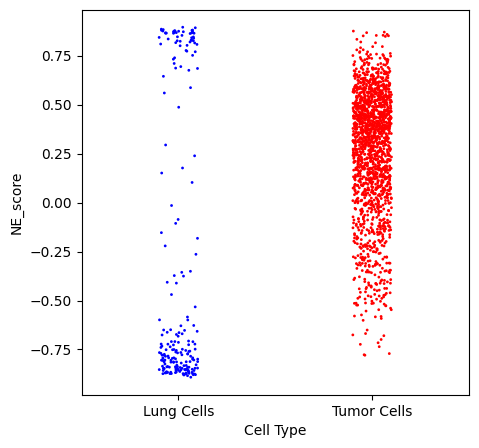

In [95]:
lung_cells_score = lung_cells_subset["NE_score"]
tumor_adata_score = tumor_adata_normalized.obs['NE_score'].dropna()

# Create a DataFrame combining the scores and labeling the sources
combined_scores = pd.DataFrame({
    'NE_score': pd.concat([lung_cells_score, tumor_adata_score]),
    'Source': ['Lung Cells'] * len(lung_cells_score) + ['Tumor Cells'] * len(tumor_adata_score)
})

# Create a dot plot with jitter for both columns
plt.figure(figsize=(5, 5))

# Create the stripplot with 'Source' as the column/category
sns.stripplot(x="Source", y="NE_score", data=combined_scores, jitter=True, size=2, palette=["blue", "red"])

# Add title and labels
plt.xlabel("Cell Type")
plt.ylabel("NE_score")

In [21]:
zhang_ne_gene_sets = {
    'NE': NE_genes,
    'non_NE': non_NE_genes
}

In [22]:
sclc_a_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_a_ccle_degs.txt"
sclc_n_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_n_ccle_degs.txt"
sclc_p_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_p_ccle_degs.txt"

In [23]:
sclc_a_degs = []
sclc_n_degs = []
sclc_p_degs = []


with open(sclc_a_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_a_degs.append(ll)

with open(sclc_n_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_n_degs.append(ll)

with open(sclc_p_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_p_degs.append(ll)

In [24]:
sclc_a_degs.sort()
sclc_n_degs.sort()
sclc_p_degs.sort()

In [25]:
sclc_subtype_gene_sets = {
    'A': sclc_a_degs,
    'N': sclc_n_degs,
    'P':sclc_p_degs
}

In [26]:
tumor_expr_matrix_df = pd.DataFrame(tumor_adata_normalized.X, index=tumor_adata_normalized.obs_names, columns=tumor_adata_normalized.var_names)

In [27]:
gs_res = gp.ssgsea(
    data=tumor_expr_matrix_df.T, # row = genes, col = cells
    gene_sets=zhang_ne_gene_sets,
    sample_norm_method='rank', # Choose from {‘rank’, ‘log’, ‘log_rank’, None}
    correl_norm_type=None, # Choose from {‘rank’, ‘symrank’, ‘zscore’, None}
    threads=4,
)

In [28]:
gs_subtype_res = gp.ssgsea(
    data=tumor_expr_matrix_df.T, # row = genes, col = cells
    gene_sets=sclc_subtype_gene_sets,
    min_size=5,
    sample_norm_method='rank', # Choose from {‘rank’, ‘log’, ‘log_rank’, None}
    correl_norm_type=None, # Choose from {‘rank’, ‘symrank’, ‘zscore’, None}
    threads=4,
)

In [29]:
ssgsea_scores = gs_res.results
ssgsea_subtype_scores = gs_subtype_res.results

In [30]:
nes_ne = []
nes_non_ne = []
cells = []

for cell_id, result in ssgsea_scores.items():
    cells.append(cell_id)
    nes_ne.append(result['NE']['nes'])
    nes_non_ne.append(result['non_NE']['nes'])  
    
nes_df = pd.DataFrame({
    'NE_ssgsea': nes_ne,
    'non_NE_ssgsea': nes_non_ne
}, index=cells)

In [31]:
sclca = []
sclcn = []
sclcp = []
cells1 = []

for cell_id, result in ssgsea_subtype_scores.items():
    cells1.append(cell_id)
    sclca.append(result['A']['nes'])
    sclcn.append(result['N']['nes'])
    sclcp.append(result['P']['nes'])
    
sclc_subtype_df = pd.DataFrame({
    'A_ssgsea': sclca,
    'N_ssgsea': sclcn,
    'P_ssgsea': sclcp
}, index=cells1)

In [32]:
for i in range(len(cells)):
    idx = tumor_adata_normalized.obs_names.get_loc(cells[i])
    tumor_adata_normalized.obs.loc[cells[i], 'NE_ssgsea'] = nes_ne[i]
    tumor_adata_normalized.obs.loc[cells[i], 'non_NE_ssgsea'] = nes_non_ne[i]

    idx2 = tumor_adata_normalized.obs_names.get_loc(cells1[i])
    tumor_adata_normalized.obs.loc[cells1[i], 'A_ssgsea'] = sclca[i]
    tumor_adata_normalized.obs.loc[cells1[i], 'N_ssgsea'] = sclcn[i]
    tumor_adata_normalized.obs.loc[cells1[i], 'P_ssgsea'] = sclcp[i]

In [33]:
tumor_adata_normalized

AnnData object with n_obs × n_vars = 1757 × 21395
    obs: 'patient', 'NT', 'tissue', 'cell_type', 'tissue_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet_score', 'predicted_doublet', 'NE_ssgsea', 'non_NE_ssgsea', 'A_ssgsea', 'N_ssgsea', 'P_ssgsea'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cells_removed', 'scrublet', 'hvg', 'pca', 'tsne', 'neighbors', 'umap', 'patient_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'log1p_norm'
    obsp: 'distances', 'connectivities'

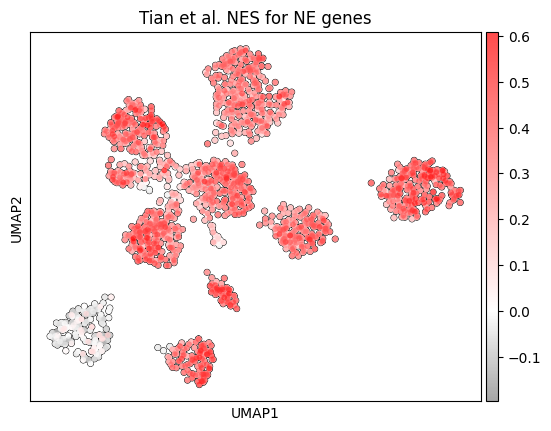

In [60]:
values = tumor_adata_normalized.obs['NE_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('grey_to_red', colors)

sc.pl.umap(tumor_adata_normalized, color='NE_ssgsea', cmap=cmap,title='Tian et al. NES for NE genes',show=False,add_outline=True,outline_width=(0.1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/plots/tian_umap_ne_score.png", dpi=600,bbox_inches='tight')

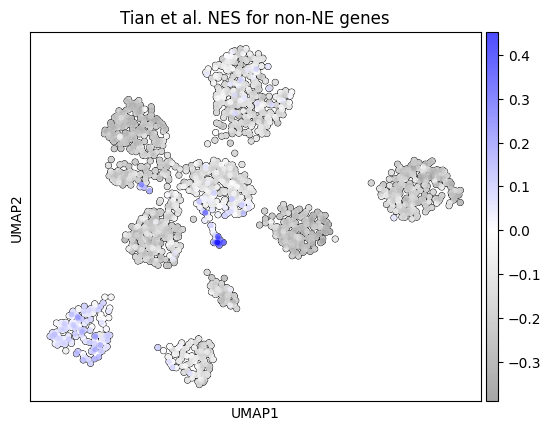

In [59]:
values = tumor_adata_normalized.obs['non_NE_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'blue')]
cmap = LinearSegmentedColormap.from_list('grey_to_blue', colors)

sc.pl.umap(tumor_adata_normalized, color='non_NE_ssgsea', cmap=cmap,title='Tian et al. NES for non-NE genes',show=False,add_outline=True,outline_width=(0.1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/plots/tian_umap_non_ne_score.png", dpi=600,bbox_inches='tight')

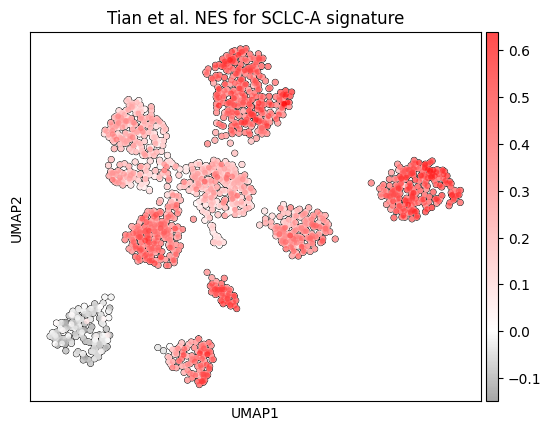

In [58]:
values = tumor_adata_normalized.obs['A_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('grey_to_red', colors)

sc.pl.umap(tumor_adata_normalized, color='A_ssgsea', cmap=cmap,title='Tian et al. NES for SCLC-A signature',show=False,add_outline=True,outline_width=(0.1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/plots/tian_umap_a_score.png", dpi=600,bbox_inches='tight')

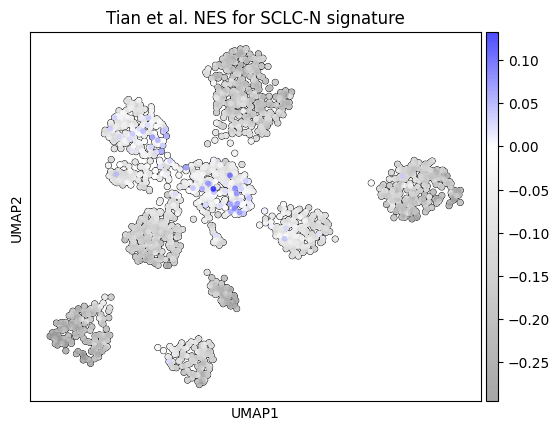

In [56]:
values = tumor_adata_normalized.obs['N_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'blue')]
cmap = LinearSegmentedColormap.from_list('grey_to_blue', colors)

sc.pl.umap(tumor_adata_normalized, color='N_ssgsea', cmap=cmap,title='Tian et al. NES for SCLC-N signature',show=False,add_outline=True,outline_width=(0.1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/plots/tian_umap_n_score.png", dpi=600,bbox_inches='tight')

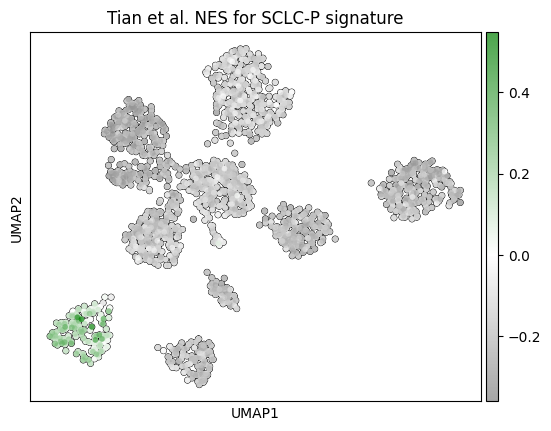

In [57]:
values = tumor_adata_normalized.obs['P_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'green')]
cmap = LinearSegmentedColormap.from_list('grey_to_green', colors)

sc.pl.umap(tumor_adata_normalized, color='P_ssgsea', cmap=cmap,title='Tian et al. NES for SCLC-P signature',show=False,add_outline=True,outline_width=(0.1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/plots/tian_umap_p_score.png", dpi=600,bbox_inches='tight')

In [39]:
tumor_adata_normalized.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/tang_adata_normalized_subtyped.h5ad")